## Imports and Set Run Parameters

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# set parameters
label = 'deaths'
lag_window = [i+7 for i in range(7)]
percent_test = 0.5

## Load and Explore Data

In [3]:
# Load Data
df_ny = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df_meta_data = pd.read_csv('../ACS_full_data_wo_over_60.csv')
# df_meta_data = pd.read_csv('https://raw.githubusercontent.com/emmamackay/ML1-Group4/master/ACS_full_data_wo_over_60.csv?token=ANUVMQO3NBFRDM64WCTGJDK6WN6NE')

## Clean/Tranform and Merge Data

In [4]:
# data clease cases - filter out entries with fewer than 10 deaths
df_ny = df_ny[['date','state','county', 'fips','cases','deaths']]
df_ny = df_ny[df_ny['deaths']>=10]
df_ny['state'] = df_ny['state'].str.lower()

In [5]:
# data clease meta - transform state for join
df_meta_data = df_meta_data.rename(str.lower, axis = 'columns')
df_meta_data['state'] = df_meta_data['state'].str.lower()

In [6]:
# merge data on cases with meta data
df_merged = pd.merge(df_ny, df_meta_data, how = 'inner', left_on=["county", "state"], right_on=["county", "state"])

In [7]:
# create lagged data
for i in (lag_window):
    df_merged[f'cases_lag{str(i+1)}'] = df_merged.groupby(['fips'])['cases'].shift((i+1))
    df_merged[f'deaths_lag{str(i+1)}'] = df_merged.groupby(['fips'])['deaths'].shift((i+1))

In [8]:
# create additional features
df_merged['pctMale'] = df_merged['e_total_pop_sex_male']/df_merged['et_total_population']
df_merged['pctSS'] = df_merged['e_total_households_with_income_with_social_security']/df_merged['et_total_population']
df_merged['pctRetInc'] = df_merged['e_total_households_with_income_with_retirement_income']/df_merged['et_total_population']
df_merged['pctWhite'] = df_merged['e_total_pop_race_white']/df_merged['et_total_population']
df_merged['pctPoverty'] = df_merged['e_total_pop_poverty_status_below_100_percent']/df_merged['et_total_population']

## Split Train and Test and Standardize Features

In [9]:
# split into train and test based on county (fips)
num_train = int(len(df_merged['fips'].unique()))
unique_counties_np = df_merged['fips'].unique()
unique_counties = pd.DataFrame(data = unique_counties_np)

train_counties = unique_counties.sample(int(num_train * (1-percent_test)))
test_counties = unique_counties.loc[~unique_counties.index.isin(train_counties.index)]

In [10]:
# extract train and test data
train_counties = train_counties[0].values.tolist()
test_counties = test_counties[0].values.tolist()
df_train = df_merged[df_merged['fips'].isin(train_counties)]
df_test =  df_merged[df_merged['fips'].isin(test_counties)]

df_train= df_train.dropna()
df_test= df_test.dropna()

In [11]:
# standardize features - train and test separately
s0 = df_train.iloc[:,4:]
df_train.iloc[:,4:] = (s0 - s0.mean()) / (s0.max() - s0.min())

s0 = df_test.iloc[:,4:]
df_test.iloc[:,4:] = (s0 - s0.mean()) / (s0.max() - s0.min())

# Model 1: RNN Implementation

In [12]:
cases_features = [f'cases_lag{i+1}' for i in (lag_window)]
deaths_features = [f'deaths_lag{i+1}' for i in (lag_window)]
static_features = ['pop_density', 'et_total_population', 'em_total_pop_median_age', 'em_transportation_mean_travel_time', 'em_total_housing_units_avg_household_size_rented', 'pctMale', 'pctSS', 'pctRetInc', 'pctWhite', 'pctPoverty']

In [13]:
# transform training features and labels
trn_x_c = df_train[cases_features].values.reshape(-1,1,len(lag_window))
trn_x_d = df_train[deaths_features].values.reshape(-1,1,len(lag_window))
trn_x_s = (df_train[static_features].values.reshape(-1,10,1) * np.ones(trn_x_c.shape[-1]))

trn_x = np.append(np.append(trn_x_c, trn_x_d, axis=1), trn_x_s, axis=1)
trn_y = np.array(df_train[[label]].values, dtype=np.float32).reshape(-1, 1)

In [14]:
# transform training features and labels
test_x_c = df_test[cases_features].values.reshape(-1,1,len(lag_window))
test_x_d = df_test[deaths_features].values.reshape(-1,1,len(lag_window))
test_x_s = (df_test[static_features].values.reshape(-1,10,1) * np.ones(test_x_c.shape[-1]))

test_x = np.append(np.append(test_x_c, test_x_d, axis=1), test_x_s, axis=1)
test_y = np.array(df_test[[label]].values, dtype=np.float32).reshape(-1, 1)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import mxnet
import mxnet.gluon as G

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [16]:
# convert to mxnet array
trn_x = mxnet.nd.array(trn_x)
trn_y = mxnet.nd.array(trn_y)

test_x = mxnet.nd.array(test_x)
test_y = mxnet.nd.array(test_y)

In [17]:
class Net(G.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            
            self.lstm = G.rnn.LSTM(hidden_size=64,num_layers=3,dropout=0.2)
            self.out = G.nn.Dense(1)
            
    def forward(self,x):
        
        x = self.lstm(x)
        x = self.out(x)
        
        return x
    
Model = Net()
print(Model)

Net(
  (lstm): LSTM(None -> 64, TNC, num_layers=3, dropout=0.2)
  (out): Dense(None -> 1, linear)
)


In [18]:
# initialize model
device = mxnet.gpu(0) if mxnet.context.num_gpus() > 0 else mxnet.cpu(0)
Model.initialize(mxnet.init.Xavier(), ctx=device)

In [19]:
trainer = G.Trainer(
    params=Model.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.01},
)

In [20]:
# define loss function
loss_function = G.loss.L2Loss()
mse = mxnet.metric.MSE()

In [21]:
from mxnet import autograd

EPOCHS = 20

trn_loss = []
test_loss = []
results_list = []

train_iter = mxnet.io.NDArrayIter(trn_x, trn_y, 100, shuffle=True)

for epoch in range(EPOCHS):
    
    for trn_batch in train_iter:

        x = trn_batch.data[0].as_in_context(device)
        y = trn_batch.label[0].as_in_context(device)
        
        with autograd.record():
            y_pred = Model(x)
            loss = loss_function(y_pred, y)
        
        #backprop
        loss.backward()
        
        #Optimize!
        trainer.step(batch_size=trn_x.shape[0])
    
    train_iter.reset()
    
    # Calculate train metrics
    
    predictions = Model(trn_x.as_in_context(device))
    mse.update(trn_y, predictions)
    trn_loss.append(mse.get()[1])
    mse.reset()
    
    predictions_test = Model(test_x.as_in_context(device))
    mse.update(test_y, predictions_test)
    test_loss.append(mse.get()[1])
    mse.reset()
    
    train_iter.reset()
    
    results_dict = {'epoch': epoch + 1, 
                'train_loss': trn_loss[-1], 
                'test_loss': test_loss[-1]}
    results_list.append(results_dict)
     
    
    print("epoch: {} | trn_loss: {:.8f}, test_loss: {:.8f}".format(epoch+1,
                                                trn_loss[-1], test_loss[-1]))

epoch: 1 | trn_loss: 0.01286454, test_loss: 0.01457923
epoch: 2 | trn_loss: 0.00651180, test_loss: 0.00886239
epoch: 3 | trn_loss: 0.00315272, test_loss: 0.00304630
epoch: 4 | trn_loss: 0.00321784, test_loss: 0.00452910
epoch: 5 | trn_loss: 0.00222453, test_loss: 0.00251449
epoch: 6 | trn_loss: 0.00295402, test_loss: 0.00347273
epoch: 7 | trn_loss: 0.00185436, test_loss: 0.00247155
epoch: 8 | trn_loss: 0.00181143, test_loss: 0.00238141
epoch: 9 | trn_loss: 0.00185608, test_loss: 0.00212338
epoch: 10 | trn_loss: 0.00159712, test_loss: 0.00210496
epoch: 11 | trn_loss: 0.00166388, test_loss: 0.00234575
epoch: 12 | trn_loss: 0.00169972, test_loss: 0.00212994
epoch: 13 | trn_loss: 0.00154963, test_loss: 0.00210239
epoch: 14 | trn_loss: 0.00220325, test_loss: 0.00304787
epoch: 15 | trn_loss: 0.00143352, test_loss: 0.00225647
epoch: 16 | trn_loss: 0.00161689, test_loss: 0.00216563
epoch: 17 | trn_loss: 0.00132282, test_loss: 0.00153343
epoch: 18 | trn_loss: 0.00135488, test_loss: 0.00162641
e

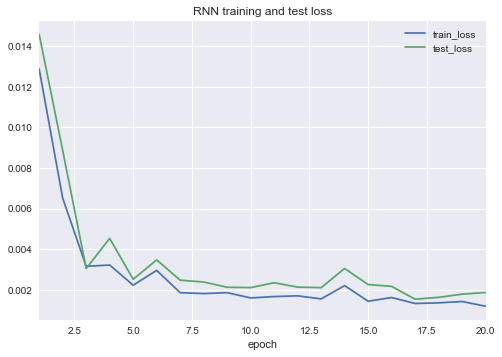

In [22]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32'})

# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title = 'RNN training and test loss')